In [1]:
'''The file that 
-Plots:
    1. target-output sine waves
    2. Loss function
    3. Spike Rasters
    4. Weight Changes
-Simulates Spike Jittering 
-Identifies Phase Tunes Neurons and Analyzes Weight Projections to and from these neurons'''

'The file that \n-Plots:\n    1. target-output sine waves\n    2. Loss function\n    3. Spike Rasters\n    4. Weight Changes\n-Simulates Spike Jittering \n-Identifies Phase Tunes Neurons and Analyzes Weight Projections to and from these neurons'

In [1]:
import numpy as torch
import matplotlib.pyplot as plt
import torch
from snntorch import spikeplot as splt
import os

In [2]:
data_dir = 'data_final'
epochs = range(0,1000,100)
batches = range(0,40)

jobs = range(0,10)
interneurons = ["3", "P", "S", "PS"]
tasks = ["A", "AP", "SC", "P"]
# torch.load(file_path, map_location="cpu", mmap=True)['task_loss']

In [6]:
exists = []
not_exists = []
for task in tasks:
    for interneuron in interneurons:
        for job in jobs:
            filename = f'task{task}_i{interneuron}_job{job}_epoch990_batch0.pth'
            filepath = os.path.join(data_dir, filename)
            if os.path.exists(filepath):
                exists.append(filename)
            else:
                not_exists.append(filename)

In [ ]:
# next 3: save loss, plot loss, k2stats loss

In [ ]:
# save loss data
import gc
import psutil

loss_data = {
    task: {interneuron: [] for interneuron in interneurons} for task in tasks
}


for task in tasks:

    for interneuron in interneurons:
        for job in jobs:
            
            job_loss = []
            path=f"data_final/task{task}_i{interneuron}_job{job}_epoch990_batch0.pth"
        
            if os.path.exists(path):
                print(f"{task}_{interneuron}_{job}")
                for epoch in epochs:
                    epoch_loss = 0           
                    
                    for batch in batches:
                        file_path = f'data_final/task{task}_i{interneuron}_job{job}_epoch{epoch}_batch{batch}.pth'  # Assuming batch 0 is representative
                        data = torch.load(file_path, map_location="cpu", mmap=True)['task_loss']
                        epoch_loss+= data

                        del data  # Explicitly delete loaded data
                        torch._C._cuda_clearCublasWorkspaces()  # Helps free internal PyTorch buffers                      
                    gc.collect() 

                    job_loss.append(epoch_loss/40) # average across 40 batches
                loss_data[task][interneuron].append(job_loss)
            else:
                print(f"no job found for {task}_{interneuron}_{job}.")
                pass

torch.save(loss_data, "plots/loss_data.pth")

A_3_0
A_3_1
A_3_2


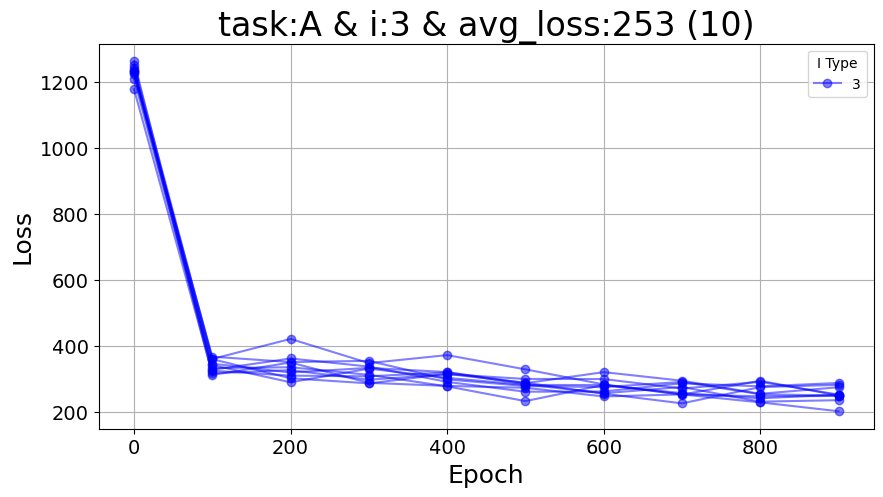

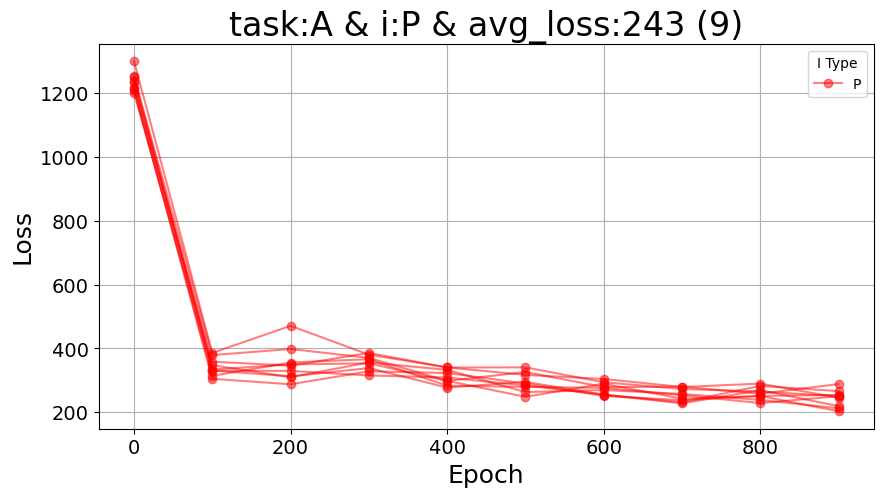

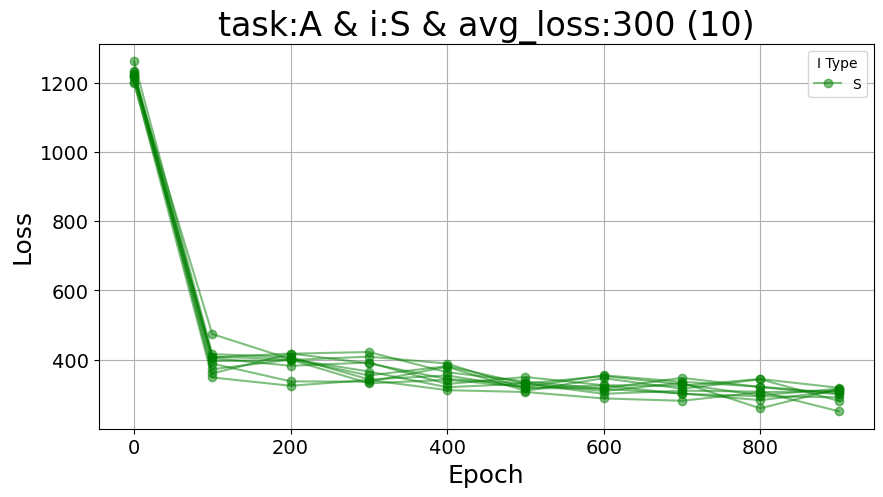

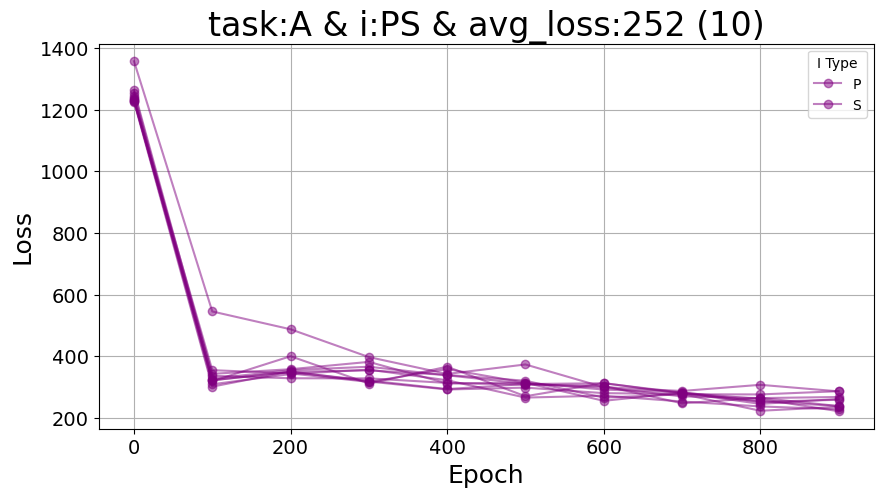

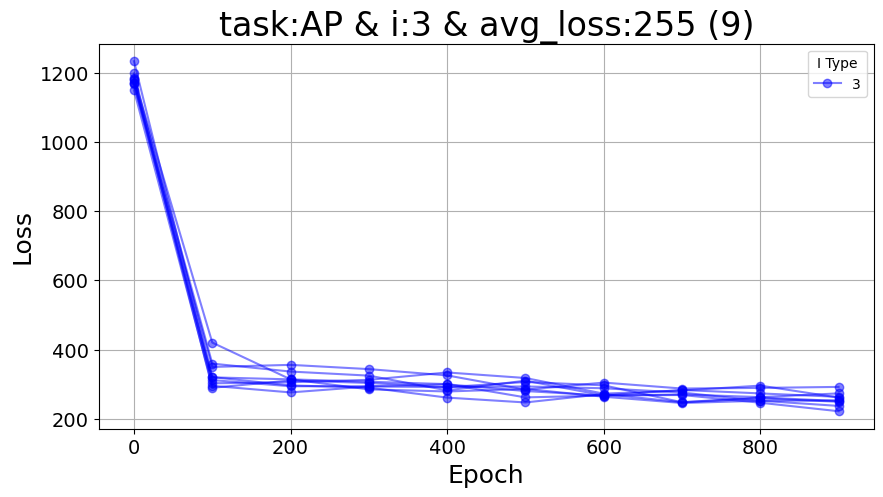

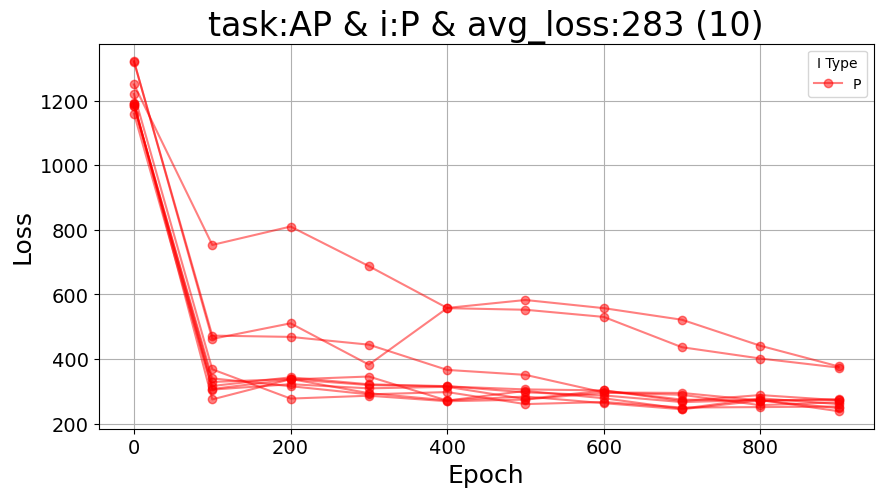

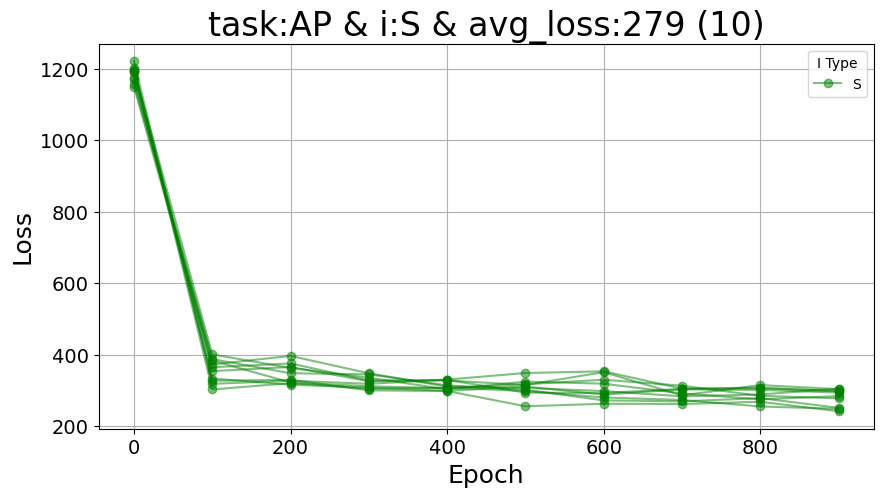

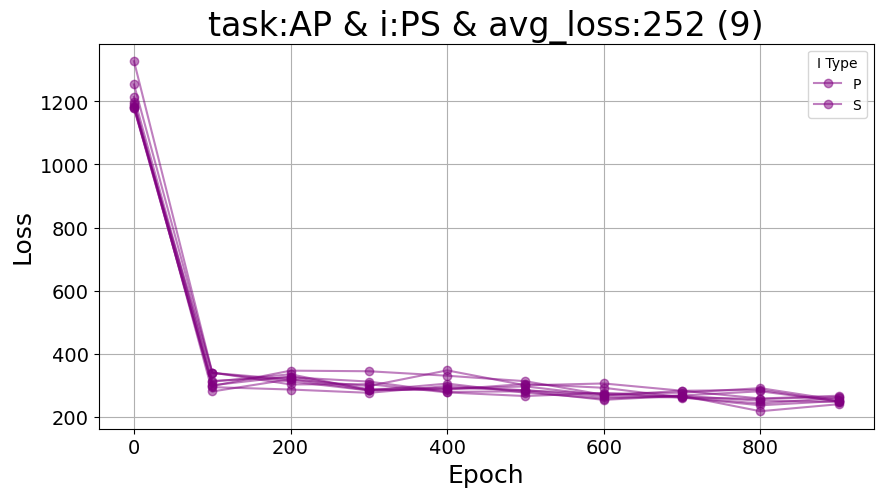

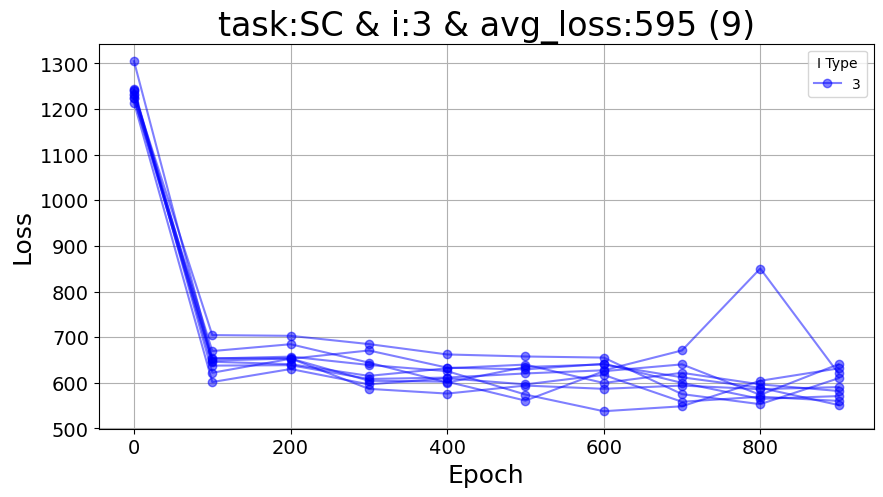

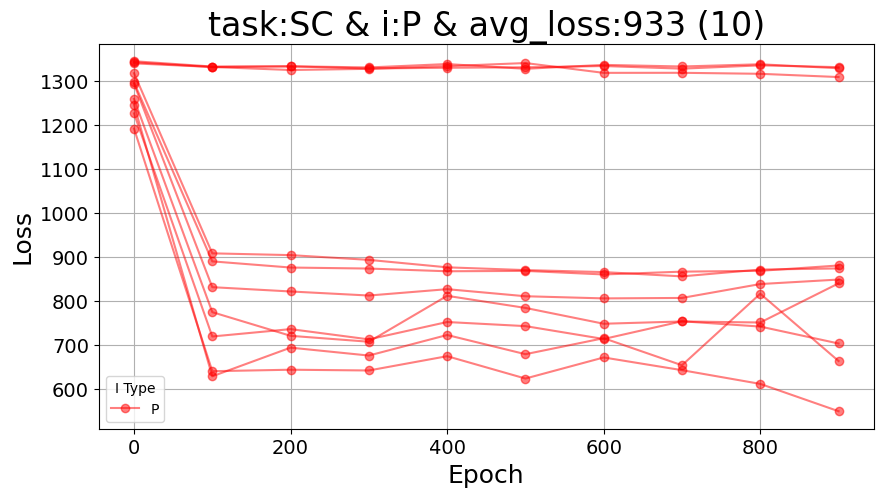

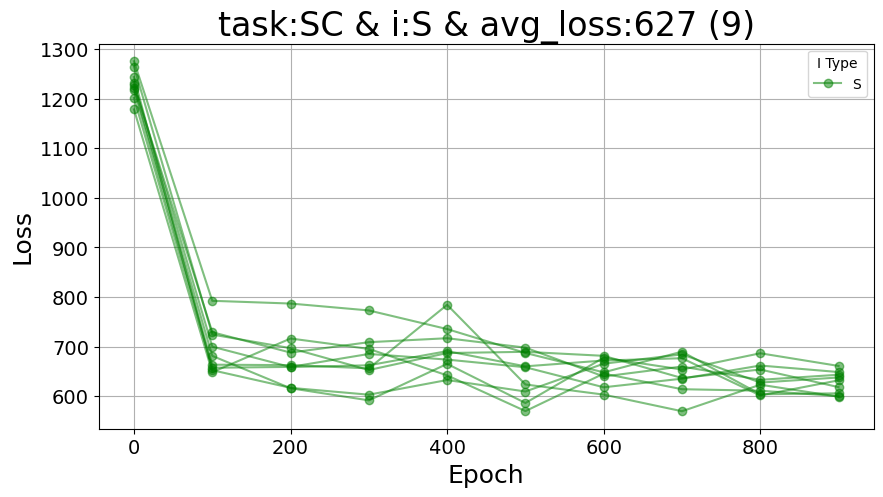

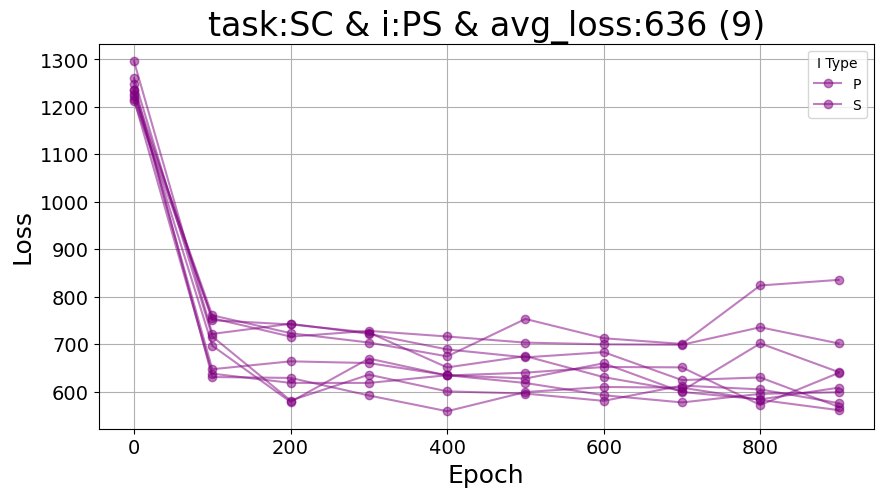

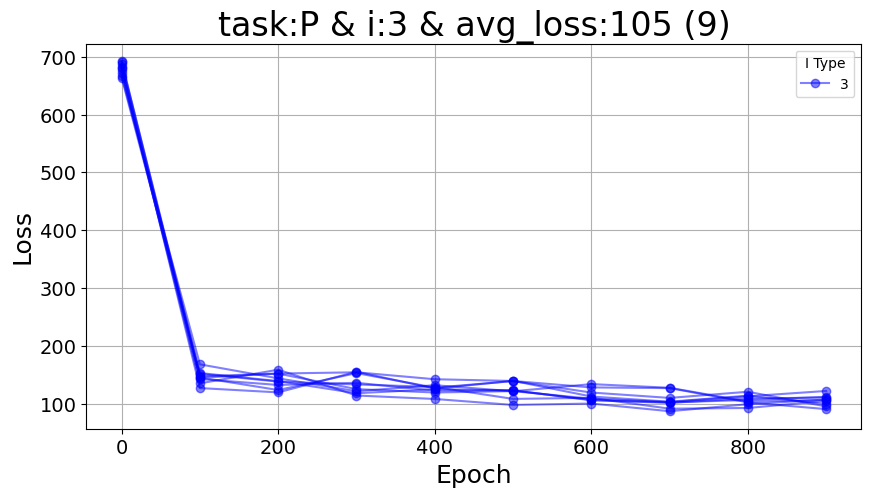

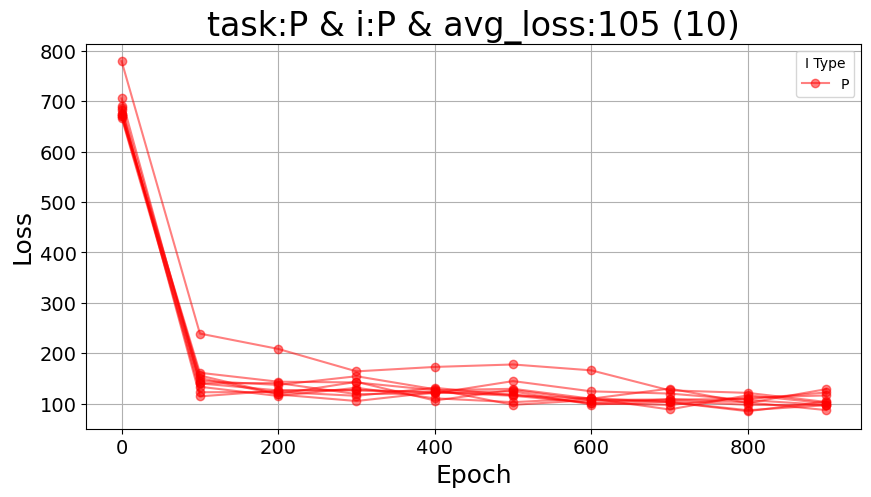

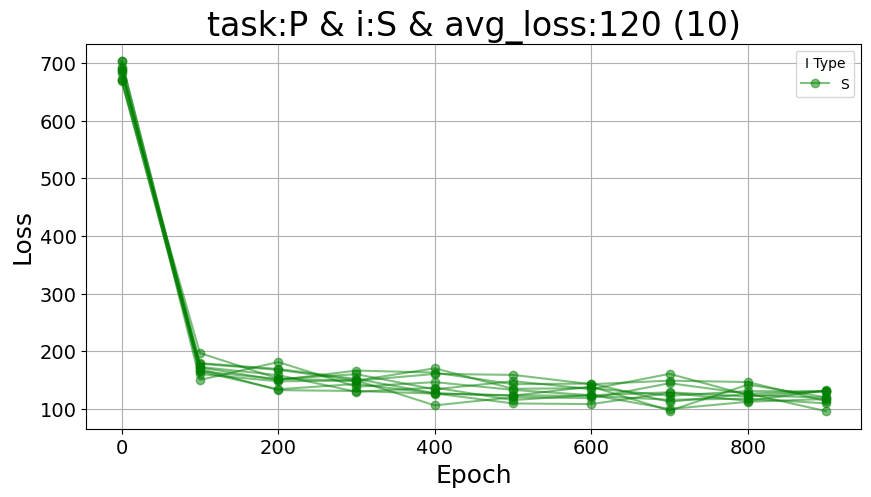

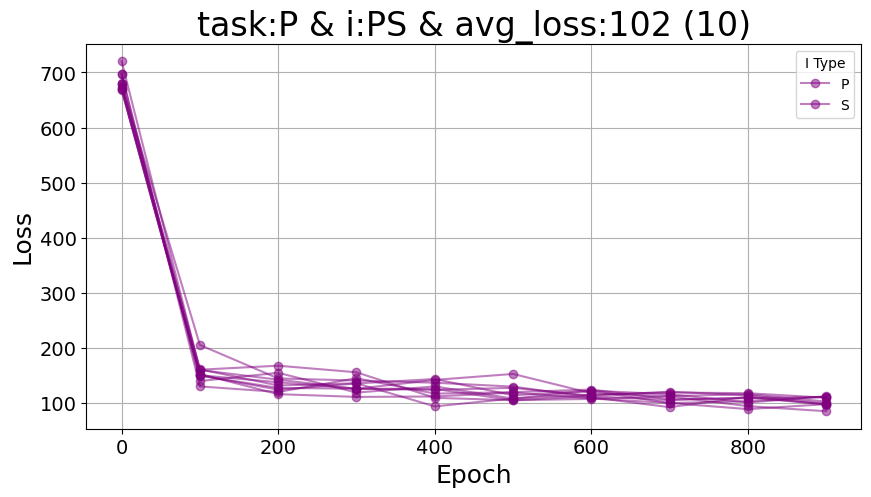

In [18]:
# plot losses per task and saves to plots/losses/loss_plot_{task}
colors = {"3": "blue", "P": "red", "S": "green", "PS": "purple"}
loss_data=torch.load("plots/loss_data.pth")
for task in tasks:
    for interneuron in interneurons:
        loss=0
        plt.figure(figsize=(10,5))
        
        loss_task_interneuron=loss_data[task][interneuron]
        len_loss=len(loss_task_interneuron)
        loss_900=torch.tensor([v[-1] for v in loss_task_interneuron])
        
        mean=torch.mean(loss_900)
        std=torch.std(loss_900)
        counter=0
        
        for job_loss in loss_task_interneuron:
            if (job_loss[-1] > (mean.item() + (2*std.item()))):
                pass
            else:
                plt.plot(epochs, job_loss, marker='o', linestyle='-', color=colors[interneuron], alpha=0.5)
                loss+=job_loss[-1]
                counter+=1
        avg_loss=int(loss/counter)
        
        plt.title(f"task:{task} & i:{interneuron} & avg_loss:{avg_loss} ({counter})", fontsize=24)
        plt.xlabel("Epoch", fontsize=18)
        plt.ylabel("Loss", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True)
        plt.legend(interneuron, title="I Type")
        plt.savefig(f"plots/losses/no_outlier_loss_{task}_{interneuron}_{avg_loss}.png")
        plt.show()

In [7]:
from scipy.stats import ks_2samp
loss_data=torch.load("plots/loss_data.pth")
p_arr=[]
s_arr=[]
ps_arr=[]
i3_arr=[]

task="P"
for interneuron in interneurons:
    for job_loss in loss_data[task][interneuron]:
        loss_task_interneuron=loss_data[task][interneuron]
        len_loss=len(loss_task_interneuron)
        loss_900=torch.tensor([v[-1] for v in loss_task_interneuron])
        
        mean=torch.mean(loss_900)
        std=torch.std(loss_900)
        counter=0
        
        if (job_loss[-1] > (mean.item() + (2*std.item()))):
            pass
        else:   
            if (interneuron=="P"):
                p_arr.append(job_loss[-1])
            if (interneuron=="S"):
                s_arr.append(job_loss[-1])
            if (interneuron=="PS"):
                ps_arr.append(job_loss[-1])
            if (interneuron=="3"):
                i3_arr.append(job_loss[-1])      

# PV vs all
D_p_s, p_p_s = ks_2samp(p_arr, s_arr)
D_p_ps, p_p_ps = ks_2samp(p_arr, ps_arr)
D_p_3, p_p_3 = ks_2samp(p_arr, i3_arr)
print(f"P-val of loss value, 10 jobs for PV vs SST is {p_p_s}")
print(f"P-val of loss value, 10 jobs for PV vs I3 is {p_p_3}")
print(f"P-val of loss value, 10 jobs for PV vs PV-SST is {p_p_ps}")

# PS vs all
D_ps_s, p_ps_s = ks_2samp(ps_arr, s_arr)
D_ps_p, p_ps_p = ks_2samp(ps_arr, p_arr)
D_ps_3, p_ps_3 = ks_2samp(ps_arr, i3_arr)
print(f"P-val of loss value, 10 jobs for PV-SST vs SST is {p_ps_s}")
print(f"P-val of loss value, 10 jobs for PV-SST vs I3 is {p_ps_3}")
print(f"P-val of loss value, 10 jobs for PV-SST vs PV is {p_ps_p}")

# SST vs all
D_s_ps, p_s_ps = ks_2samp(s_arr, ps_arr)
D_s_p, p_s_p = ks_2samp(s_arr, p_arr)
D_s_3, p_s_3 = ks_2samp(s_arr, i3_arr)
print(f"P-val of loss value, 10 jobs for SST vs PV is {p_s_p}")
print(f"P-val of loss value, 10 jobs for SST vs I3 is {p_s_3}")
print(f"P-val of loss value, 10 jobs for SST vs PV-SST is {p_s_ps}")

# I3 vs all
D_i3_p, p_i3_p = ks_2samp(i3_arr, p_arr)
D_i3_s, p_i3_s = ks_2samp(i3_arr, s_arr)
D_i3_ps, p_i3_ps = ks_2samp(i3_arr, ps_arr)
print(f"P-val of loss value, 10 jobs for I3 vs PV is {p_i3_p}")
print(f"P-val of loss value, 10 jobs for I3 vs SST is {p_i3_s}")
print(f"P-val of loss value, 10 jobs for I3 vs PV-SST is {p_i3_ps}")
            

P-val of loss value, 10 jobs for PV vs SST is 0.05244755244755244
P-val of loss value, 10 jobs for PV vs I3 is 0.4424646560869471
P-val of loss value, 10 jobs for PV vs PV-SST is 0.7869297884777761
P-val of loss value, 10 jobs for PV-SST vs SST is 0.002056766762649115
P-val of loss value, 10 jobs for PV-SST vs I3 is 0.7869297884777761
P-val of loss value, 10 jobs for PV-SST vs PV is 0.7869297884777761
P-val of loss value, 10 jobs for SST vs PV is 0.05244755244755244
P-val of loss value, 10 jobs for SST vs I3 is 0.012340600575894693
P-val of loss value, 10 jobs for SST vs PV-SST is 0.002056766762649115
P-val of loss value, 10 jobs for I3 vs PV is 0.4424646560869471
P-val of loss value, 10 jobs for I3 vs SST is 0.012340600575894693
P-val of loss value, 10 jobs for I3 vs PV-SST is 0.7869297884777761


In [ ]:
# OUTPUT - TARGET SINE WAVES

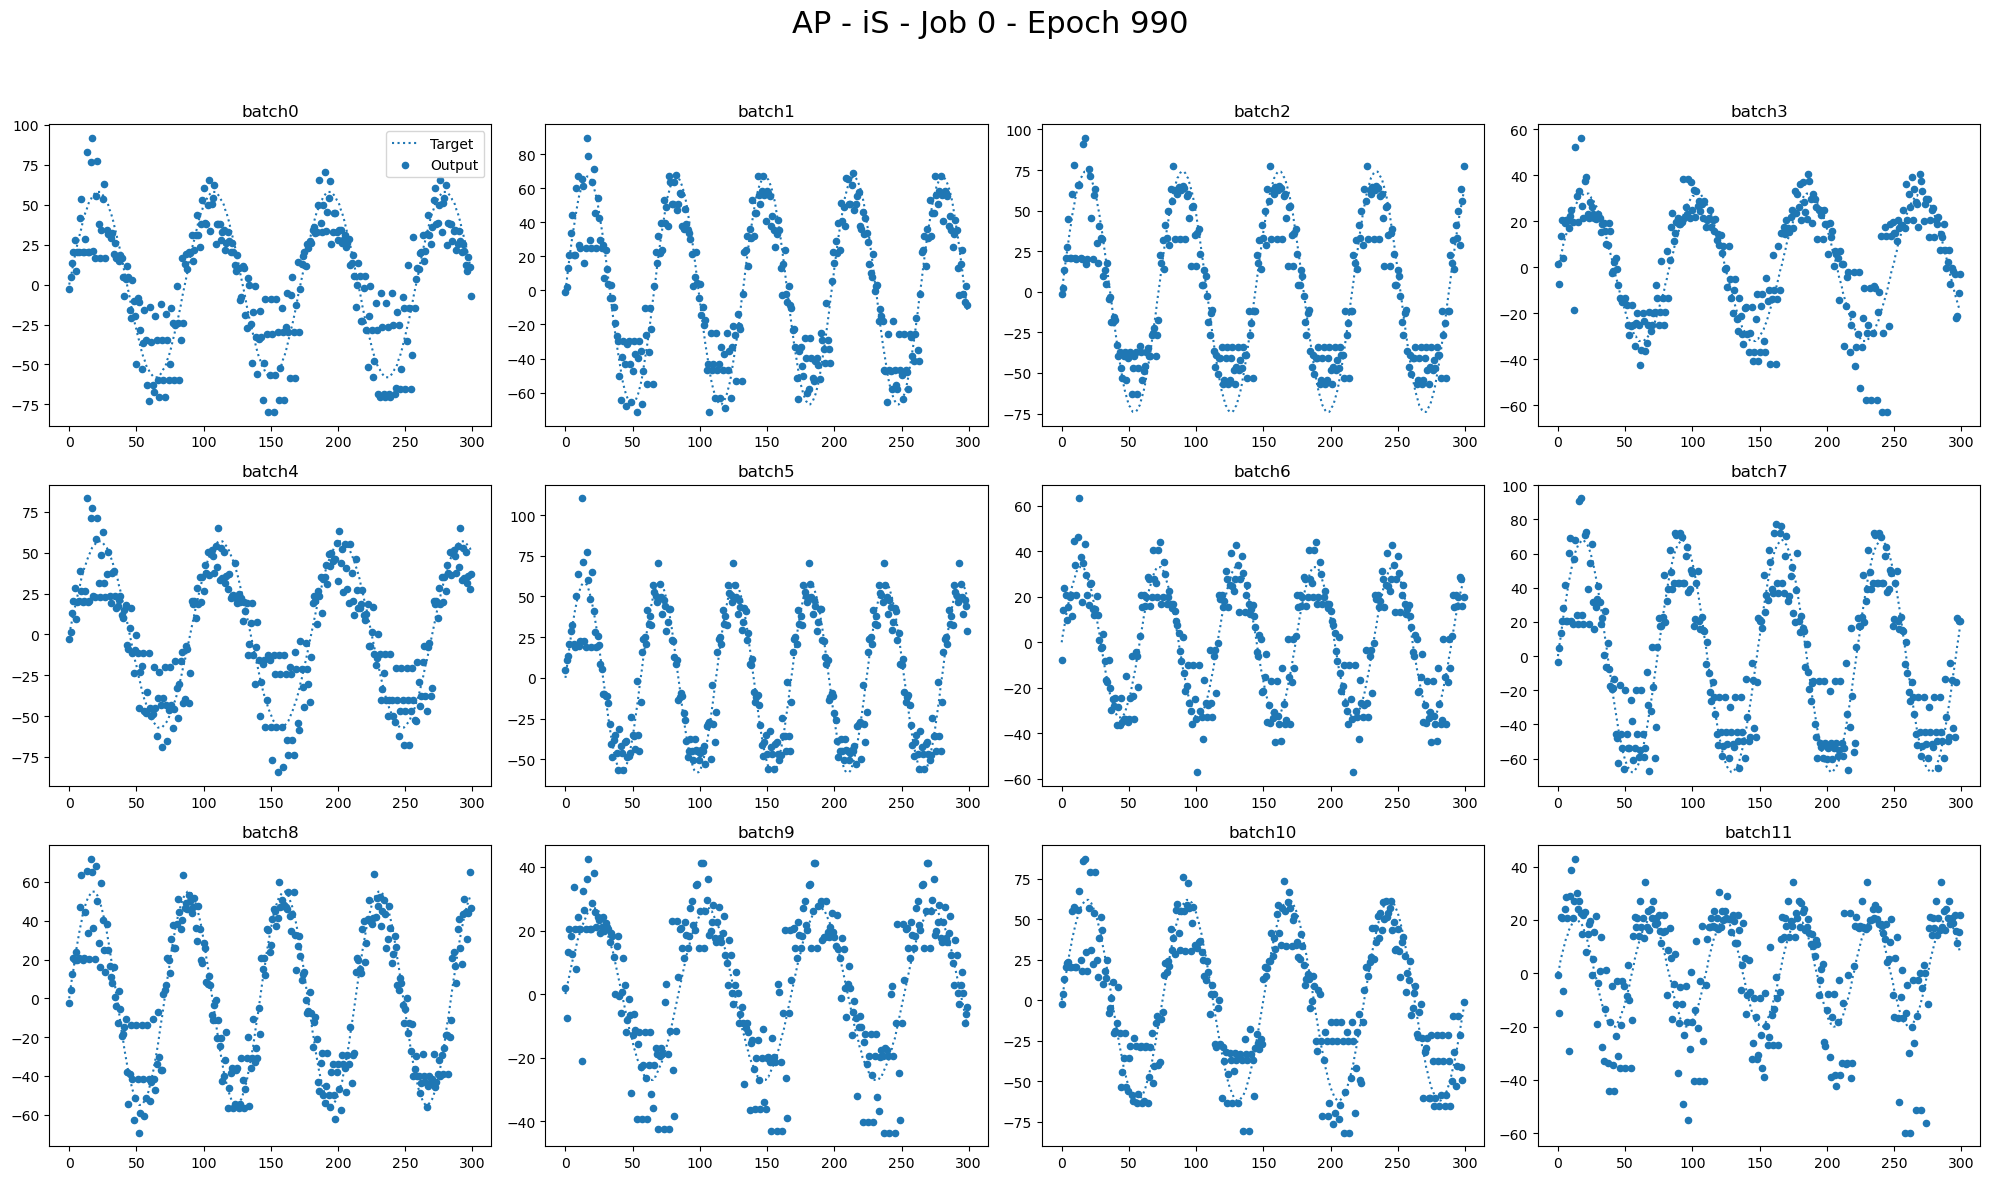

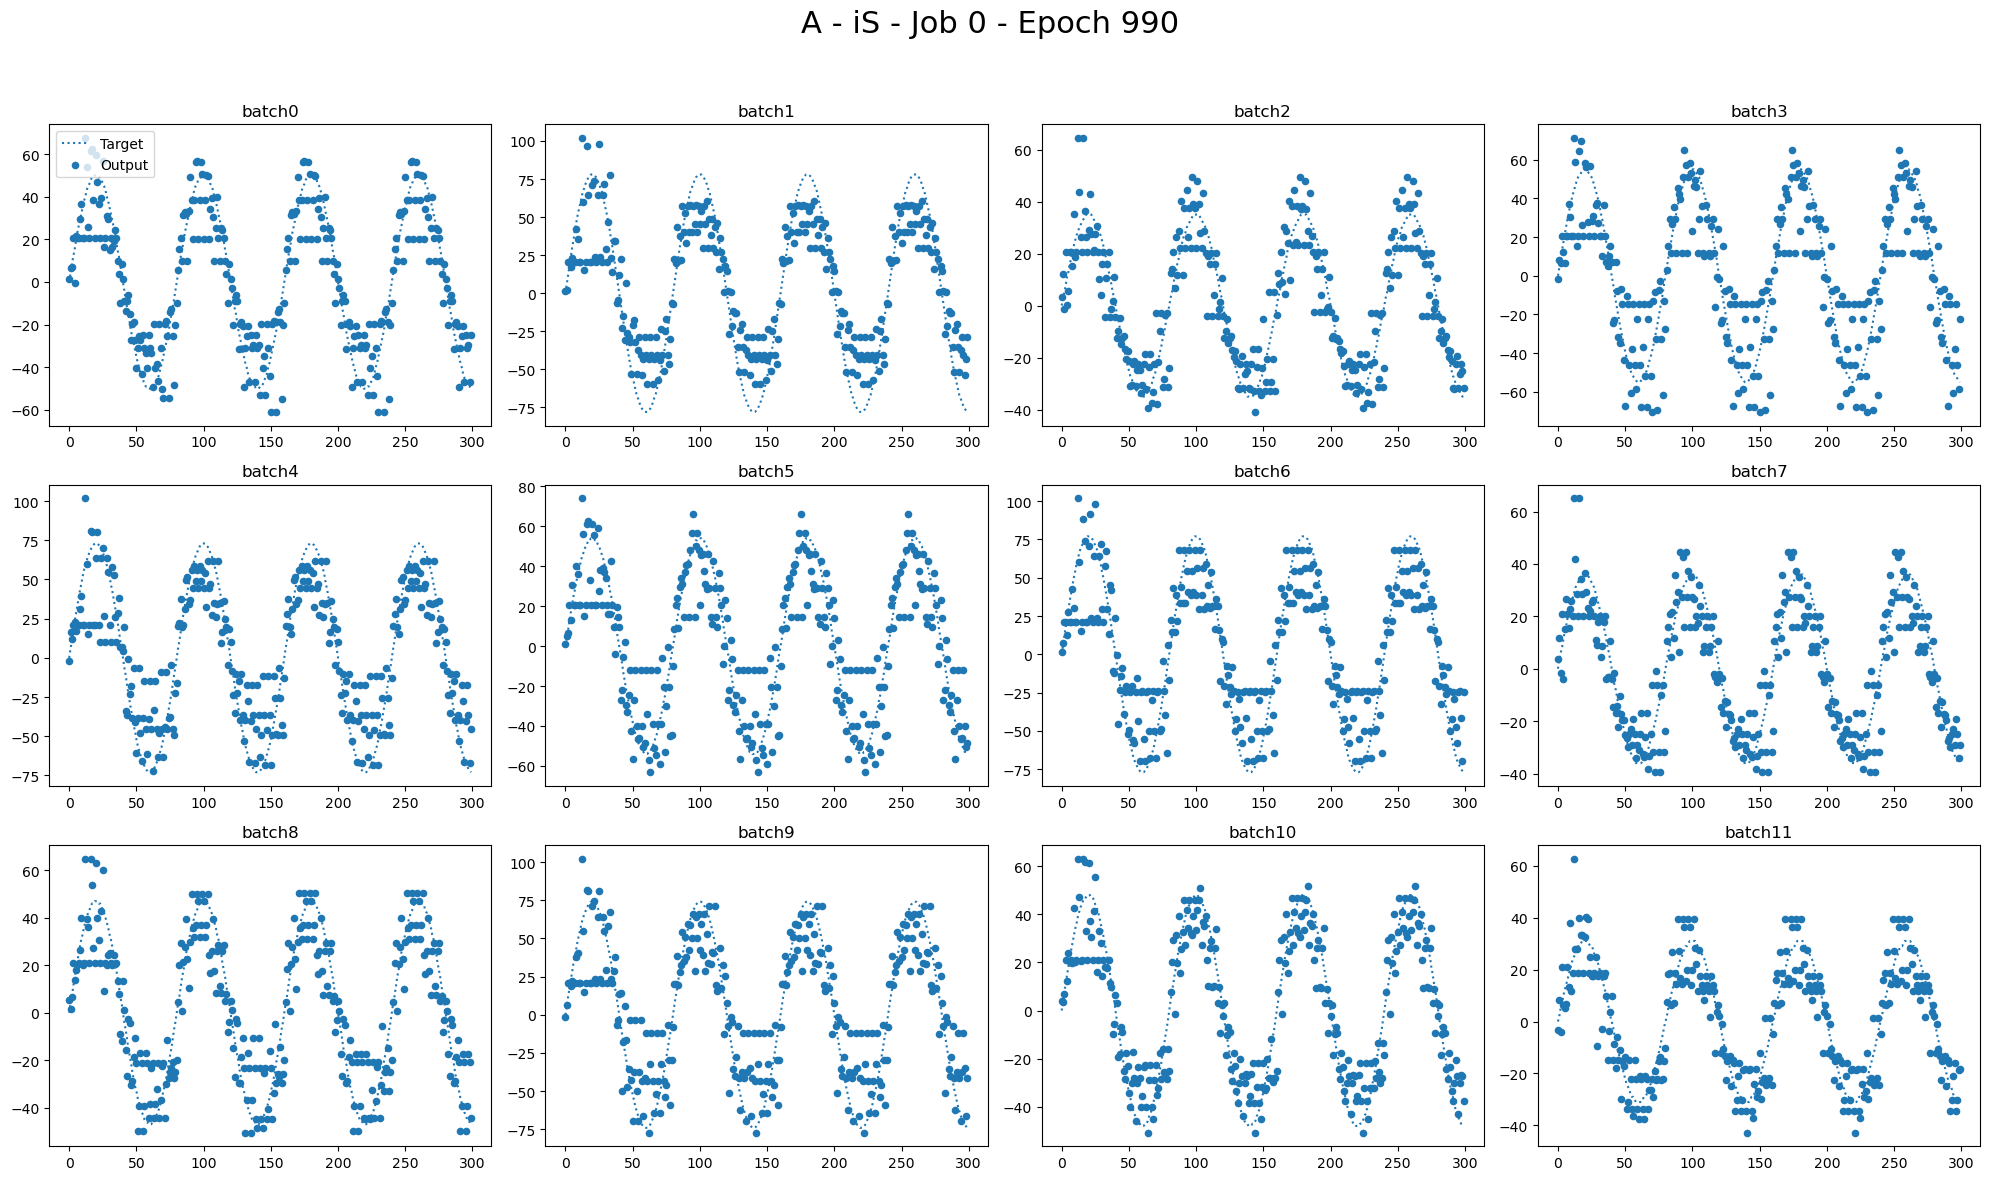

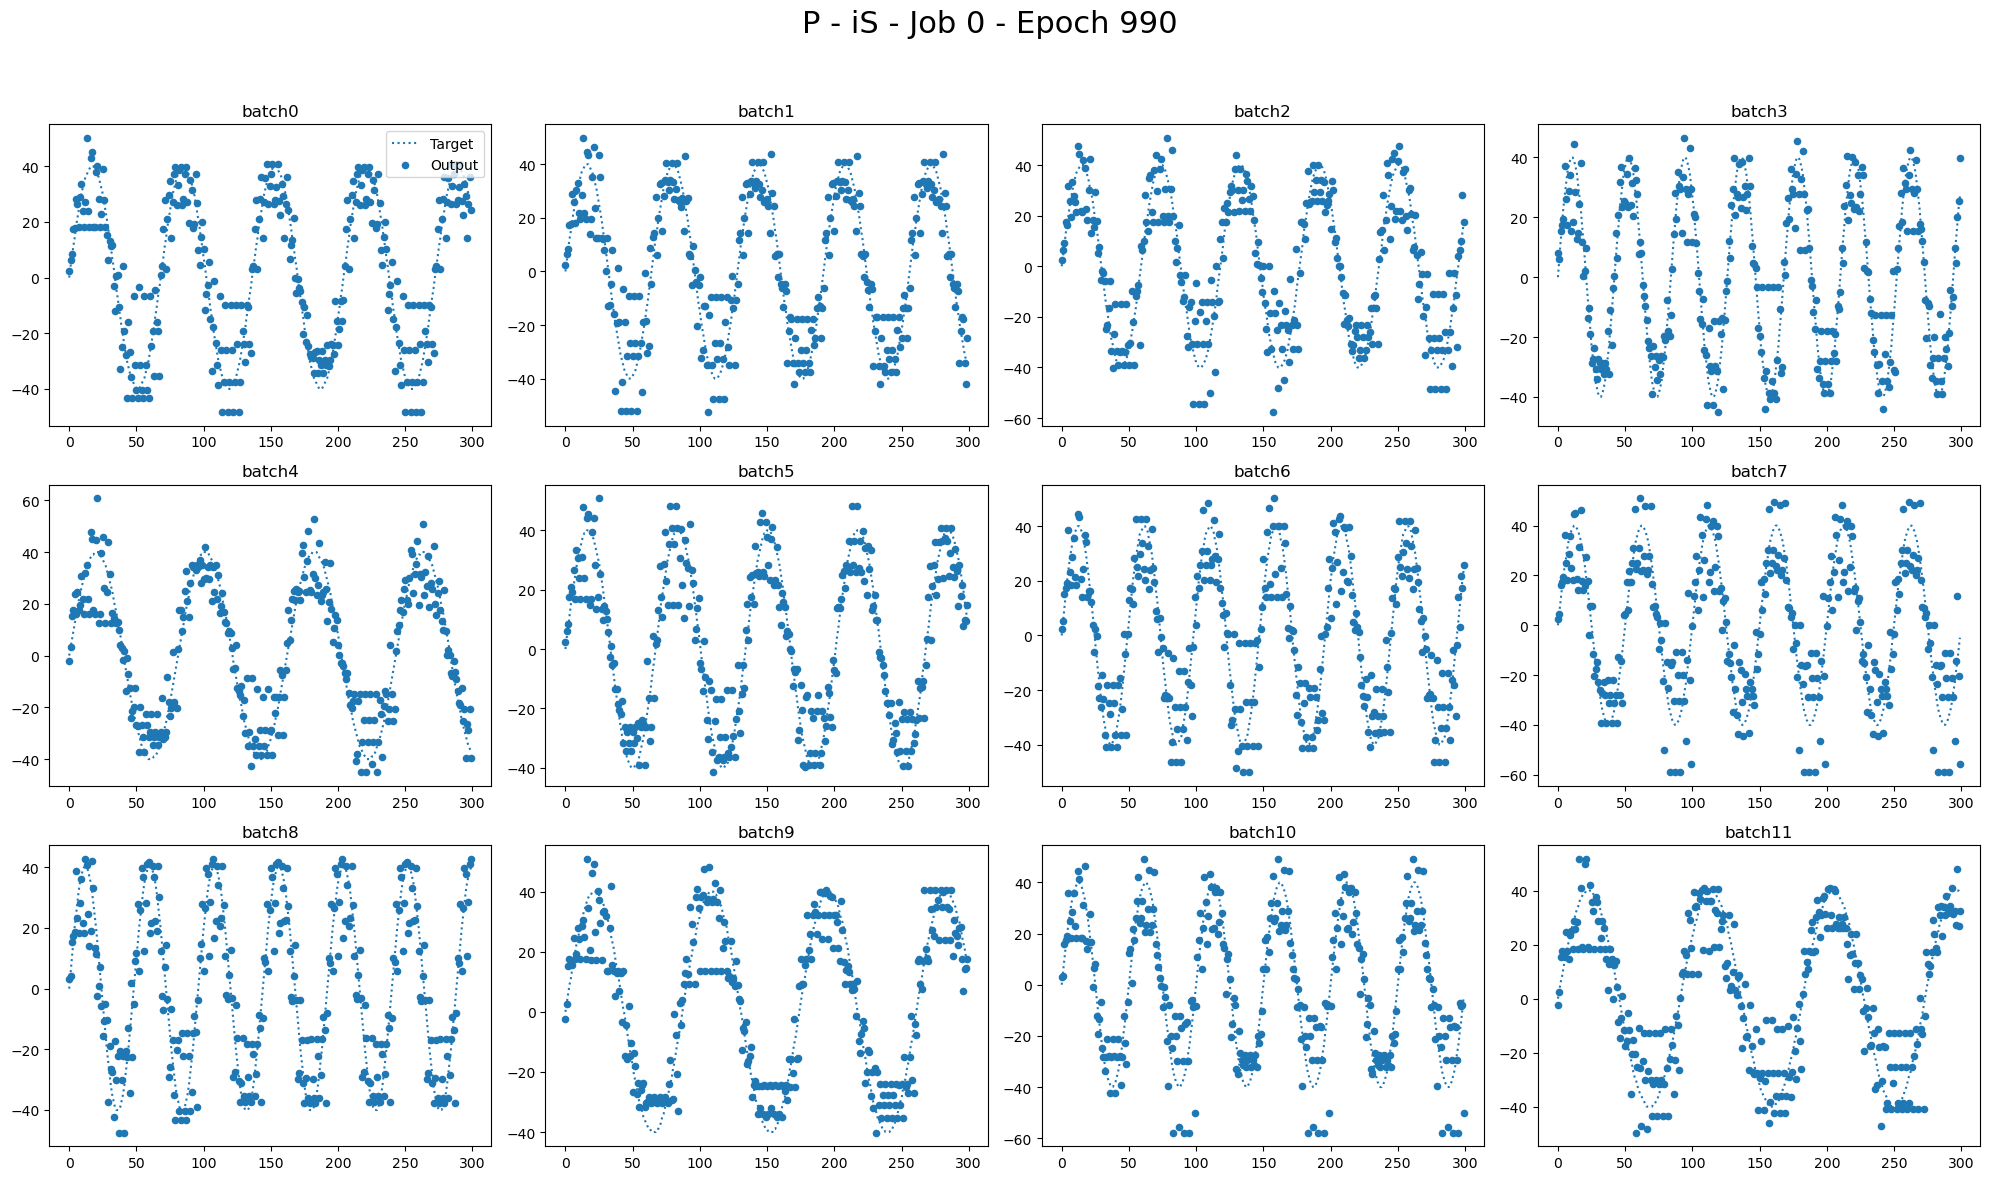

In [19]:
tasks=["AP","A","P"]
interneuron="S"
for task in tasks:
    fig, axs = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(f'{task} - i{interneuron} - Job 0 - Epoch 990 ', fontsize=22)
    
    for batch in range(12):
        file_path = f'data_final/task{task}_i{interneuron}_job0_epoch990_batch{batch}.pth'
        targets = torch.load(file_path)["targets"][0].detach()# [25,200,300]
        outputs = torch.load(file_path)["outputs"][0].detach()# [25,300]

        ax=axs[int(batch/4),batch%4]
        ax.plot(targets, linestyle='dotted',label=f'Target')
        ax.scatter(range(len(outputs)), outputs, label=f'Output', s=20)  # s=20 makes the dots smaller

        ax.set_title(f'batch{batch}')
        ax.tick_params(axis='both', labelsize=10)
        if batch == 0:
            ax.legend(fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"plots/sine_wave/{task}_i{interneuron}_j0_epoch990.png")
    plt.show()

# file_path = f'data_final/task{task}_i{interneuron}_job0_epoch990_batch{batch}.pth'
# targets = torch.load(file_path)["targets"][0].detach()# [25,200,300]
# outputs = torch.load(file_path)["outputs"][0].detach()# [25,300]
# plt.plot(targets, linestyle='dotted',label=f'Target')
# plt.scatter(range(len(outputs)), outputs, label=f'Output', s=20)  # s=20 makes the dots smaller
# plt.set_title(f'batch{batch}')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('Amplitude', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend()
# plt.show()

In [22]:
'''OUTPUT - TARGET SINE WAVES'''
import numpy as torch

data_dir = 'data_final'

# Initialize lists to hold target and output data for each epoch
targets_list = []
outputs_list = []
batch=0
spikes_list = []
save_dir = "plots/sine_wave"


for task in tasks:
    for interneuron in interneurons:
        for job in jobs:
            loss = 0
            file_path = f'data_final/task{task}_i{interneuron}_job{job}_epoch990_batch0.pth'

            if os.path.exists(file_path):
                data = torch.load(file_path)
                
                targets = data["targets"][0] # [25,200,300]
                outputs = data['outputs'][0] # [25,300]
                
                # getting respective loss value
                loss_name = f'data_final/task{task}_i{interneuron}_job{job}_epoch990_batch0.pth'
                data_loss = torch.load(loss_name,map_location="cpu", mmap=True)['task_loss']
                loss += data_loss

            
                # save figure
                plt.figure(figsize=(10, 5))
                plt.plot(targets, linestyle='dotted',label=f'Target {job+1}')
                plt.scatter(range(len(outputs)), outputs, label=f'Output {job+1}', s=20)  # s=20 makes the dots smaller

                plt.title(f'Wave_{task}_{interneuron}_{job}_loss{int(loss)}')
                plt.xlabel('Time', fontsize=18)
                plt.ylabel('Amplitude', fontsize=18)
                plt.xticks(fontsize=14)
                plt.yticks(fontsize=14)
                plt.legend()

                file_name = f"Sine_task{task}_I{interneuron}_job{job}_loss{int(loss)}.png"
                plt.show()
                # save_path = os.path.join(save_dir, file_name)
                # plt.savefig(save_path, bbox_inches='tight', dpi=300)
                # plt.close()  # Close the figure to free memory
                
            else:
                print(f"File {file_name} not found.")


KeyError: 'targets is not a file in the archive'

In [17]:
# combine spike wave plots per task plots.
# Directory containing the plots
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict

plots_dir = "plots/sine_wave"

# Organize images by task
task_plots = defaultdict(list)

# Find all PNG files in the directory
png_files = glob.glob(os.path.join(plots_dir, "*.png"))  # Recursively get all PNGs

# filter files with losses 0
filtered_files = [name for name in png_files if not name.endswith("loss0.png")]

# Group plots by task
for file in filtered_files:
    filename=os.path.basename(file)
    suffix = ".png"
    if  filename.endswith(suffix):
        filename = filename[:-len(suffix)]  # Extracts "category-subjectid-task.png"
    filename = filename[5:]    
    parts = filename.split("_")  # Split by '_'
    
    task, interneuron, job, loss = parts[0], parts[1], parts[2], parts[3]  
    task_plots[task].append((file, interneuron, job, loss))

# Generate combined plots for each subject
output_dir = "plots/combined_waves"
os.makedirs(output_dir, exist_ok=True)

for task, plots in task_plots.items():
    num_plots = len(plots)
    cols = 4  # Limit columns to 4 for readability
    rows = (num_plots + cols - 1) // cols  # Compute rows based on number of plots

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figure size
    fig.suptitle(f"{task} across I types", fontsize=16, y = 0.95)

    # Flatten axes if only one row or column
    axes = axes.flatten() if num_plots > 1 else [axes]

    for ax, (file, interneuron, job, loss) in zip(axes, sorted(plots, key=lambda x: int(x[3][4:]))):  # Sort by category
        img = mpimg.imread(file)
        ax.imshow(img)
        # Define the title color based on interneuron type
        if interneuron == "IP":
            color = 'red'
        elif interneuron == "IS":
            color = 'green'
        elif interneuron == "IPS":
            color = 'blue'
        else:
            color = 'black' # Default color if none match

        ax.set_title(f"{interneuron}_{loss}", color=color, fontsize=10, y=0.95)
        ax.axis("off")

    # Hide unused subplots if any
    for i in range(len(plots), len(axes)):
        axes[i].axis("off")

    # Save the combined figure
    plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust layout to fit title
    output_path = os.path.join(output_dir, f"{task}.png")
    plt.savefig(output_path, dpi=300)
    plt.close()

print(f"Combined plots saved in {output_dir}")

Combined plots saved in plots/combined_rasters


In [ ]:
# SPIKE RASTERS

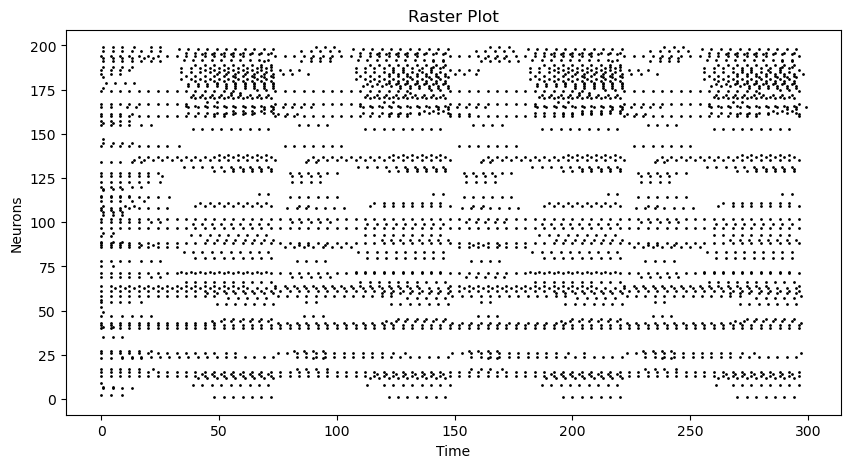

In [7]:
# # SPIKE RASTER 1

data_dir = 'data_final'
file_name = f'taskAP_i3_job0_epoch990_batch39.pth'
file_path = os.path.join(data_dir, file_name)
spikes = torch.load(file_path, map_location="cpu", mmap=True)['spikes']
#shape [25, 200, 300]
spike=spikes[0]

plt.figure(figsize=(10, 5))
y, x = torch.where(spike == 1)
plt.scatter(x,y,marker='o', color='black', s=1)

# for neuron, spike_train in enumerate(spikes):
#     #spike times per neuron
#     spike_times = torch.where(spike_train > 0) 
#     plt.vlines(spike_times, neuron - 0.2, neuron + 0.2)
    
plt.title(f'Raster Plot')
plt.xlabel('Time')
plt.ylabel('Neurons')
plt.show()

In [ ]:
# SPIKE RASTERS
# train_data saved 1 spike array (200,300) per batch. So per each epoch, there is 40 spikes. 

interneurons = ["3", "P", "S", "PS"]
tasks = ["A", "AP", "SC", "P"]
jobs = range(5)
data_dir = "data_final"
epochs = range(0, 1000, 100)
batchs = range(40)
spikes_list = []
save_dir = "plots/scatter"
# Load spikes data from pth files
for task in tasks:
    for interneuron in interneurons:
        for j in jobs: 
            for i, epoch in enumerate(epochs):
                loss = 0
                file_name = f'task{task}_i{interneuron}_job{j}_epoch{epoch}_batch0.pth'
                file_path = os.path.join(data_dir, file_name)

                if os.path.exists(file_path):
                    data = torch.load(file_path)

                    #spikes: (200,300)
                    spikes = data['spikes'][:]
                    
                    for batch in batchs:
                        file_name_batch = f'task{task}_i{interneuron}_job{j}_epoch{epoch}_batch{batch}.pth'
                        data_batch = torch.load(f"data_final/{file_name_batch}")
                        loss += data['task_loss']

                    #spikes_list:(100,200,300)
                    spikes_list.append(spikes)

                    plt.figure(figsize=(10, 5))
                    for neuron, spike_train in enumerate(spikes):

                        #spike times per neuron
                        spike_times = torch.where(spike_train > 0)  
                        plt.vlines(spike_times, neuron - 0.2, neuron + 0.2)

                    plt.title(f'Raster_task{task}_i{interneuron}_j{j}_epoch{epoch}_loss{int(loss)}')
                    plt.xlabel('Time', fontsize=18)
                    plt.ylabel('Neuron Index',fontsize=18)
                    plt.xticks(fontsize=14)
                    plt.yticks(fontsize=14)

                    file_name = f"Raster_task{task}_i{interneuron}_j{j}_epoch{epoch}_loss{int(loss)}.png"
                    save_path = os.path.join(save_dir, file_name)
                    plt.savefig(save_path, bbox_inches='tight', dpi=300)
                    plt.close()  # Close the figure to free memory
        
                else:
                    print(f"no data for {file_path}")



In [3]:
# example name: taskAP_IS_job2_loss7684
# combine raster plots per task plots.
# Directory containing the plots

import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict

plots_dir = "plots/scatter"

# Organize images by task
task_plots = defaultdict(list)

# Find all PNG files in the directory
png_files = glob.glob(os.path.join(plots_dir, "*.png"))  # Recursively get all PNGs

# filter files with losses 0
filtered_files = [name for name in png_files if not name.endswith("loss0.png")]

# Group plots by task
for file in filtered_files:
    filename=os.path.basename(file)
    suffix = ".png"
    if  filename.endswith(suffix):
        filename = filename[:-len(suffix)]  # Extracts "category-subjectid-task.png"
    filename = filename[7:]    
    parts = filename.split("_")  # Split by '_'
    
    task, interneuron, job, epoch, loss = parts[0], parts[1], parts[2], parts[3], parts[4]  
    task_plots[task].append((file, interneuron, job, epoch, loss))

# Generate combined plots for each subject
output_dir = "plots/combined_rasters"
os.makedirs(output_dir, exist_ok=True)

for task, plots in task_plots.items():
    # unique_epochs = sorted(set(int(epoch[5:]) for _, _, _, epoch, _ in plots), key=int)
    # print(unique_epochs)
    # for epoch in unique_epochs:
        epoch_str = f"epoch990"
        epoch_plots = [p for p in plots if p[3] == epoch_str]
        num_plots = len(epoch_plots)
        cols = 4  # Limit columns to 4 for readability
        rows = (num_plots + cols - 1) // cols  # Compute rows based on number of plots

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))  # Adjust figure size
        fig.suptitle(f"{task}_epoch990_acrossIs", fontsize=16, y = 1)

        # Flatten axes if only one row or column
        axes = axes.flatten() if num_plots > 1 else [axes]
        
        epoch_plots_sorted = sorted(epoch_plots, key=lambda x: int(x[4][4:]))

        for ax, (file, interneuron, job, _, loss) in zip(axes, epoch_plots_sorted):  # Sort by category
            img = mpimg.imread(file)
            ax.imshow(img)
            # Define the title color based on interneuron type
            if interneuron == "iP":
                color = 'red'
            elif interneuron == "iS":
                color = 'green'
            elif interneuron == "iPS":
                color = 'blue'
            else:
                color = 'black' # Default color if none match

            ax.set_title(f"{interneuron}_{loss}", color=color, fontsize=10, y=0.95)
            ax.axis("off")

        # Hide unused subplots if any
        for i in range(len(plots), len(axes)):
            axes[i].axis("off")

        # Save the combined figure
        plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust layout to fit title
        output_path = os.path.join(output_dir, f"{task}_990.png")
        plt.savefig(output_path, dpi=300)
        plt.close()

print(f"Combined plots saved in {output_dir}")

Combined plots saved in plots/combined_rasters


In [63]:
# PLOT AVG INHIBITORY & AVG EXCITATORY ACTIVITY PER EPOCH 
# (ACROSS ALL SPIKES)
# idx 0 = inh, idx 1 = exc
import numpy as np
avgspike_data = {
    task: {interneuron: [[],[]] for interneuron in interneurons} for task in tasks
}

for task in tasks:
    # Load spikes data from pth files
    for interneuron in interneurons:
        # Initialize arrays to hold spike sums
        inh_spike_ar,exc_spike_ar = [],[]

        for job in jobs: 
            inh_epoch_spikes,exc_epoch_spikes=0,0
            file_path = f'data_final/task{task}_i{interneuron}_job{job}_epoch990_batch{batch}.pth'
            
            if os.path.exists(file_path):
                for batch in batches:
                    spikes = torch.load(file_path)['spikes'] #[25,200,300]

                    # Sum I & E spikes across all 25 rasters
                    inh_epoch_spikes+=torch.sum(spikes[:,160:200,:]).item()
                    # print(inh_epoch_spikes)
                    exc_epoch_spikes+=torch.sum(spikes[:,0:160,:]).item()

                # one entry per each job - all samples from 990th epoch
                inh_spike_ar.append(inh_epoch_spikes/(25*40*40))
                exc_spike_ar.append(exc_epoch_spikes/(25*40*160))
            else:
                    print(f"{file_path} doesn't exist")

    
        # inh_spike_ar has 10 elem for each job
        # {'A': {'3': [[[1229787.0, 1107479.0...
        avgspike_data[task][interneuron][0]=inh_spike_ar
        avgspike_data[task][interneuron][1]=exc_spike_ar
    
torch.save(avgspike_data, "plots/average_spike_per_neuron.pth")

data_final/taskA_i3_job3_epoch990_batch39.pth doesn't exist
data_final/taskSC_i3_job4_epoch990_batch39.pth doesn't exist
data_final/taskSC_i3_job9_epoch990_batch39.pth doesn't exist
data_final/taskSC_iP_job4_epoch990_batch39.pth doesn't exist
data_final/taskSC_iP_job5_epoch990_batch39.pth doesn't exist
data_final/taskSC_iP_job6_epoch990_batch39.pth doesn't exist
data_final/taskSC_iP_job7_epoch990_batch39.pth doesn't exist
data_final/taskSC_iP_job8_epoch990_batch39.pth doesn't exist
data_final/taskSC_iP_job9_epoch990_batch39.pth doesn't exist
data_final/taskSC_iS_job4_epoch990_batch39.pth doesn't exist
data_final/taskSC_iS_job5_epoch990_batch39.pth doesn't exist
data_final/taskSC_iS_job6_epoch990_batch39.pth doesn't exist
data_final/taskSC_iS_job7_epoch990_batch39.pth doesn't exist
data_final/taskSC_iS_job8_epoch990_batch39.pth doesn't exist
data_final/taskSC_iS_job9_epoch990_batch39.pth doesn't exist
data_final/taskSC_iPS_job4_epoch990_batch39.pth doesn't exist
data_final/taskSC_iPS_jo

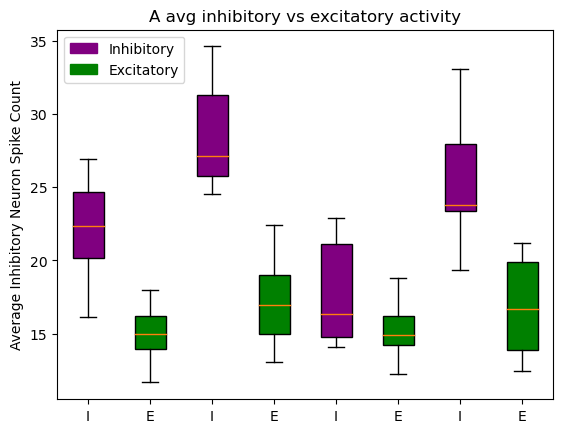

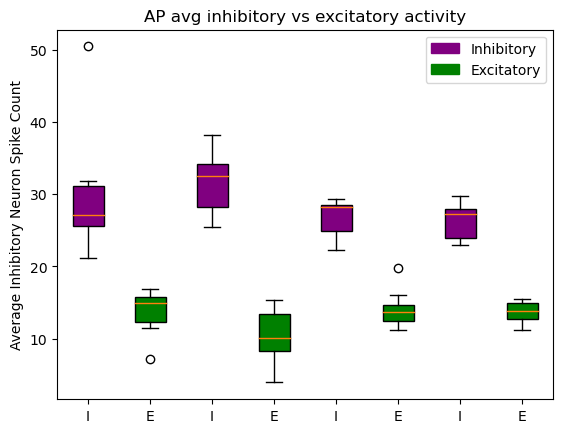

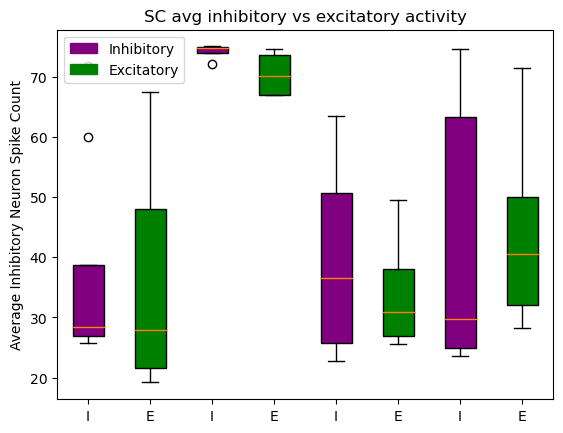

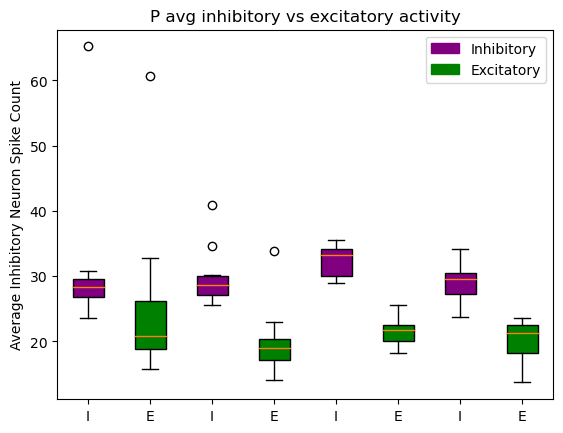

In [69]:
# box plots of average inhibitory spike vs excitatory spike
import matplotlib.patches as mpatches
avgspike_data=torch.load("plots/average_spike_per_neuron.pth")
boxes={task:[] for task in tasks}
for task in tasks:
    for interneuron in interneurons:
        boxes[task].append(avgspike_data[task][interneuron][0])
        boxes[task].append(avgspike_data[task][interneuron][1])

for task in tasks:
    xlabels=["I","E","I","E","I","E","I","E"]
    fig, ax = plt.subplots()
    ax.set_ylabel("Average Inhibitory Neuron Spike Count")
    bplot = ax.boxplot(boxes[task],
                       patch_artist=True,  # fill with color
                       labels=xlabels)

    colors=["purple","green","purple","green","purple","green","purple","green"]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Creating legend manually
    inhibitory_patch = mpatches.Patch(color="purple", label="Inhibitory")
    excitatory_patch = mpatches.Patch(color="green", label="Excitatory")
    ax.legend(handles=[inhibitory_patch, excitatory_patch])

    plt.title(f"{task} avg inhibitory vs excitatory activity")
    # plt.savefig(f"plots/spike_per_neuron/boxAP.png")
    plt.show()

In [154]:
# Calculate how many weights increased/decreased drastically
def load_weights(pth_file):
    in_weights=torch.load(pth_file)['input_weights'].T
    rec_weights = torch.load(pth_file)['rec_weights'].T
    output_weights = torch.load(pth_file)['output_weights'].T  # Shape: 1x200
    return in_weights,rec_weights, output_weights

# inp_0,rec_0, out_0 =load_weights('data_final/taskAP_i3_job0_epoch0_batch0.pth')
# inp_990,rec_990, out_990 =load_weights('data_final/taskAP_i3_job0_epoch990_batch0.pth')

In [136]:
count_above_20 = torch.sum(rec_990[:160,:] > 0).item()
count_below_5 = torch.sum(rec_990[160:,:] > 0).item()
    
print("count_above_20",count_above_20, "count_below_5",count_below_5)

count_above_20 6694 count_below_5 0


In [84]:
count_above_20 = torch.sum(out_weights > 0).item()
count_below_5 = torch.sum(out_weights < -0).item()
print("out_above_0",count_above_20, "out_below_0",count_below_5)

out_above_0 62 out_below_0 124


KeyboardInterrupt: 

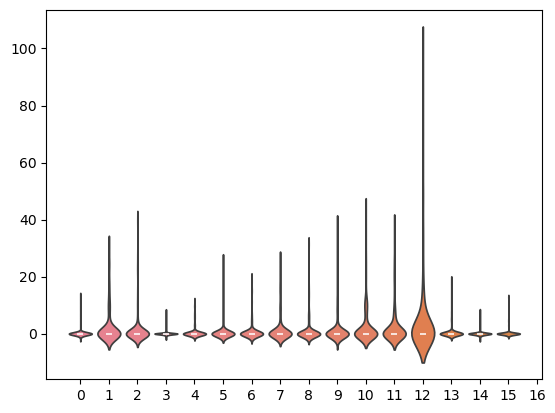

In [142]:
import seaborn as sns
rec_0_990=rec_990-rec_0
# recl_0=rec_0.detach()
# recl_990=rec_990.detach()
# recl_0_990=rec_0_990.detach()

# out_0_990=out_990-out_0
# outl_0=out_0.detach()
# outl_990=out_990.detach()
# outl_0_990=out_0_990.detach()

Text(0.5, 1.0, 'Output Weight Change Epoch 0-990')

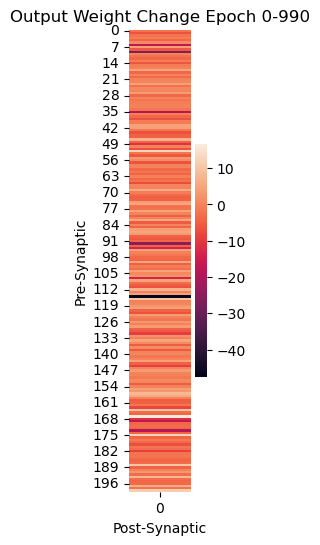

In [113]:
fig, ax = plt.subplots(figsize=(1, 6))

# sns.heatmap(outl_0)
# ax=sns.heatmap(outl_990)
ax=sns.heatmap(outl_0_990)
ax.set(xlabel="Post-Synaptic", ylabel="Pre-Synaptic")
ax.set_title("Output Weight Change Epoch 0-990")

In [170]:

"""# violin plots for change of weights for excitatory and inhibitory 
# projections across tasks and interneurons"""
average_weights ={
}
task,interneuron,job="AP","3","0"
epochs=range(0,990,10)

# first inh, then exc
in_wchange,rec_wchange,out_wchange=[],[[],[]],[]
for epoch in epochs:
    inp,rec,out =load_weights(f'data_final/task{task}_i{interneuron}_job{job}_epoch{epoch}_batch0.pth')
    inp1,rec1,out1 =load_weights(f'data_final/task{task}_i{interneuron}_job{job}_epoch{epoch+10}_batch0.pth')
    in_change,rec_change,out_change=abs(inp1-inp),abs(rec1-rec),abs(out1-out)
    
    inw=torch.sum(in_change).item()/600
    rec_exc,rec_inh=torch.sum(rec_change[0:160,]).item()/(40*200),torch.sum(rec_change[160:,]).item()/(160*200)
    outw=torch.sum(out_change).item()/200

    in_wchange.append(inw)
    rec_wchange[0].append(rec_inh)
    rec_wchange[1].append(rec_exc)
    out_wchange.append(outw)

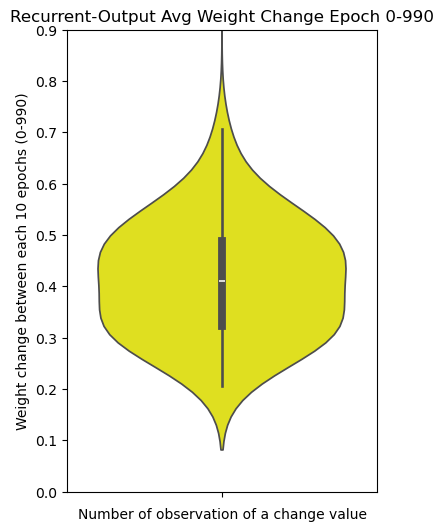

In [203]:
fig, ax = plt.subplots(figsize=(4,6))

# sns.violinplot(y=in_wchange,color="Blue",ax=ax)
# sns.violinplot(rec_wchange[1],color="Green",ax=ax)
# sns.violinplot(rec_wchange[0],color="Purple",ax=ax)
sns.violinplot(out_wchange,color="Yellow",ax=ax)

ax.set(xlabel="Number of observation of a change value", ylabel="Weight change between each 10 epochs (0-990)")
ax.set_title("Recurrent-Output Avg Weight Change Epoch 0-990")
ax.set_ylim(0, 0.9)  # Set y-axis limits
plt.show()

In [ ]:
# Plot weight changes (for the recurrent and output layer) between epoch 0th epoch and each next 20th epoch.
# First plot (0-20), second (0-40) ... (0-480)

import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to store weight differences
rec_weight_diffs = []
output_weight_diffs = []

# Define epochs to compare
epochs_to_compare = range(0, 500, 100)  # From epoch 0 to epoch 400 in steps of 20

# Function to plot heatmap
def plot_heatmap(data, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, cmap="viridis", annot=False)
    plt.title(title)
    plt.show()
    
epoch_file1 = f'dataMP/level8_loss0_epoch0_batch0.pth'
rec_weight1, output_weight1 = load_weights(epoch_file1)
# Load and compare weights for each pair of epochs
for epoch in epochs_to_compare:
    epoch_file2 = f'dataMP/level8_loss0_epoch{epoch}_batch39.pth'  # Assuming batch 19 has the last recorded batch
    # Load weights for epoch
    rec_weight2, output_weight2 = load_weights(epoch_file2)
    
    # Compute the change in weights
    Rec_weight_change = rec_weight2 - rec_weight1
    output_weight_change = output_weight2 - output_weight1

    # Plot heatmaps
    plot_heatmap(Rec_weight_change, f'Recurrent Weight Change at Epoch {epoch}')
    plot_heatmap(output_weight_change, f'Output Weight Change at Epoch {epoch}')



In [ ]:
file_name = f'level2_loss0_epoch{480}_batch{39}.pth'
file_path = os.path.join(data_dir, file_name)
    
if os.path.exists(file_path):
    data = torch.load(file_path)
    spikes = data['spikes']
    rec_mx = torch.from_numpy(data['rec_weights']).T #200x200
    out_layer = data['output_weights']
    itorchuts = torch.from_numpy(data['itorchuts'][-1]).T
    

In [ ]:
# helper function that counts num_spikes
def count_ones(tens):
    num_ones = 0
    for i in tens:
        if i == 1: num_ones += 1
    return num_ones

#print period value
print(itorchuts[1,0])

In [ ]:
'''calculate all the neurons that are only active in one state of the sine wave, either positive or negative
(calculate number of phase tuned neurons)

ADJUST DEPENDING ON YOUR PERIOD. 
Each 0th index of a new tuple should be the 
incremented multiple of the period value. Below is an example for period=71'''

positive_ranges = [(0, 28),(71, 88), (142, 147),(213, 206),(284, 206),(236,265),(295,300)]
spikes = torch.from_numpy(spikes)
spikes = spikes.to(torch.int)
# Convert ranges to mask for positive_sine neurons
positive_mask = torch.zeros(300, dtype=torch.bool)
for start, end in positive_ranges:
    positive_mask[start:end+1] = True

# Invert the mask for negative_sine neurons
negative_mask = ~positive_mask

# Lists to store indices of positive_sine and negative_sine neurons
positive_sine_indices = []
negative_sine_indices = []
zero_tensor = torch.zeros(spikes.shape[1])

# Iterate through each neuron
for i in range(spikes.shape[0]):
    neuron_firings = spikes[i, :]

    # Classify the neuron
    if torch.all(neuron_firings == zero_tensor) | count_ones(neuron_firings) < 3:
        pass
    elif torch.all(neuron_firings & positive_mask == neuron_firings)&torch.all(neuron_firings & negative_mask == zero_tensor):
        positive_sine_indices.append(i)
    elif torch.all(neuron_firings & negative_mask == neuron_firings)&torch.all(neuron_firings & positive_mask == zero_tensor):
        negative_sine_indices.append(i)

# Output the results
print("Positive sine neuron indices:", positive_sine_indices)
print("Negative sine neuron indices:", negative_sine_indices)



In [ ]:
'''Experiment with projections from a single neuron.
Identify state tuned neurons using the code above, replace 179 with the index number
Check for strong weights that the neuron projects.
'''
print(rec_mx[179,:])

# Find the indices where the weight entries are less than -30 (for inhibitory) or more than 30
indices = torch.nonzero(rec_mx[179, :] > 30).squeeze()
indices1 = torch.nonzero(rec_mx[179, :] < -30).squeeze()


# Print the indices
print(indices)
print(indices1)

In [ ]:
# plot a spike raster and try to observe the phase tuned neurons!

plt.figure(figsize=(10, 5))
for neuron, spike_train in enumerate(spikes[:,:]):
    spike_times = torch.where(spike_train > 0)[0]  # Assuming spikes are indicated by positive values
    plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)

plt.title(f'Raster Plot of Spikes\nEpoch {460} Batch {batch} Training Index 24')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.show()

In [ ]:
'''Jitter all 300ms worth of spikes with a number between (-4, 4) '''

import random
pos_neg_indices = sorted(positive_sine_indices + negative_sine_indices)

def generate_nonzero_random():
    while True:
        num = int(random.uniform(-4, 4))  # Generate a random float between -4 and 4
        if num != 0:
            return num
        
spikes1 = torch.zeros([200,300])
for neur in range(spikes1.shape[0]):
    for timestep in range(spikes.shape[1]):
        if spikes[neur,timestep] == 1:
            jitter = generate_nonzero_random()
            if (timestep+jitter >= 0) & (timestep+jitter < 300):
                spikes1[neur,timestep+jitter] = 1
            

In [ ]:
# Scatter plot of jittered spikes
plt.figure(figsize=(10, 5))
for neuron, spike_train in enumerate(spikes1):
    spike_times = torch.where(spike_train > 0)[0]  # Assuming spikes are indicated by positive values
    plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)

plt.title(f'Raster Plot of Spikes\nEpoch {480} Batch {batch} Training Index 24')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.show()

In [ ]:
# Plot the output-target pairs with jittered spike to check for robustness
out_layer = torch.from_numpy(out_layer)
out_layer = out_layer.to(float)
spikes1 = spikes1.to(float)
output = torch.matmul(spikes1.T, out_layer.T)
targets = data['targets'][24]
      

# Plotting the target and output sine waves for each epoch
plt.figure(figsize=(10, 5))
plt.plot(targets, linestyle='dotted',label=f'Target {i+1}')
plt.plot(output, linestyle='dotted', label=f'Output {i+1}')

plt.title(f'Target and Output Sine Waves\nEpoch 480 Batch {batch}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Instantiate apt variables for the experiment of jittering first 10 ms of spikes

data_dir = 'dataMP'
file_name = 'level51_loss0_epoch480_batch39.pth'
file_path = os.path.join(data_dir, file_name)

if os.path.exists(file_path):
        data = torch.load(file_path)
        #shape 200x200 and 1x200,epoch 480, batch 39, training data 24
        l1_mx = torch.from_numpy(data['itorchut_weights']).T  #2x200
        rec_mx = torch.from_numpy(data['rec_weights']).T #200x200
        l2_mx = torch.from_numpy(data['output_weights']).T #200x1
        itorchuts = torch.from_numpy(data['itorchuts'][-1]).T
        spikes = torch.from_numpy(data['spikes'])
        targets = data['targets'][-1]
        outputs = data['outputs'][-1]



In [ ]:
#Jitter first 10 ms of spikes

spikes1 = torch.zeros([200,300])
# print(spikes[:20,:10])
for neur in range(200):
    for timestep in range(10):
        if spikes[neur,timestep] == 1:
            jitter = generate_nonzero_random()
            # print(jitter)
            if (timestep+jitter >= 0) & (timestep+jitter < 10):
                # spikes1[neur,timestep] = 0
                spikes1[neur,timestep+jitter] = 1

In [ ]:
# Instantiate a new RSNN with the already trained model variables 

from classes.helper1 import conn_mx, hid_mx
from classes.RLIF1 import RLIF1
import torch.nn as nn


#set the rec_mx and output layer matrix to already trained model (trained on sinewave0 dataloader train_data_hpc0)
#set the itorchut layer 3x200: first row to first row, and third row to second row of the trained model
class RSNN400(nn.Module):
    def __init__(self):
        super(RSNN400, self).__init__()
        num_itorchuts = 3
        num_hidden = 200
        num_output = 1
        beta = 0.85
        pe_e = 0.16

        # Define the dimensions
        num_excitatory = 160
        self.num_excitatory = num_excitatory
        num_inhibitory = 40
        self.false_neg = []
        self.false_pos = []

        #itorchut to hidden layer
        # itorchut_hid_mx = conn_mx(num_itorchuts, num_hidden, pe_e)
        # itorchut_hid_mx= l1_mx 
        # self.itorchut_hid_mx = itorchut_hid_mx
        self.l1 = nn.Linear(num_itorchuts,num_hidden)
        self.l1.weight.data = l1_mx.T

        # Recurrent layer weight matrix        
        self.rlif1 = RLIF1(reset_mechanism="zero", beta=beta, threshold=1.0,linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = rec_mx.T

        #hidden to output layer
        # hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output)
        self.l2.weight.data = l2_mx.T
        
        self.spk1_rec = []
        self.cur2_rec = []
        self.spk1,self.mem1 = self.rlif1.init_rleaky()


    def forward(self, itorchuts, spk1, mem1):
        cur1 = self.l1(itorchuts)
        spk1, mem1 = self.rlif1(cur1, spk1, mem1)
        cur2 = self.l2(spk1)
        
        self.mem1 = mem1

        return cur2, spk1, mem1

In [ ]:
# Initialize spikes and membrane potentials
net_400 = RSNN400()
spk1 = net_400.spk1
mem1 = net_400.mem1
spk_list = []
mem_list = []
spikes1 = spikes1.to(torch.float32)

In [ ]:
#jitter the spikes for the first 10 ms, and run the network on jittered initial spikes. 
for i in range(300):
    # print(itorchuts.dtype)
    if i < 10:
        spk1 = spikes1[:, i]
        net_400.spk1_rec.append(spk1)
        mem1 = net_400.mem1  # Update membrane potential if needed
        cur2, spk1, mem1 = net_400.forward(itorchuts[:, i], spk1, mem1)
        net_400.cur2_rec.append(cur2)
    else:
        # For the remaining timesteps, run the network normally
        cur2, spk1, mem1 = net_400.forward(itorchuts[:, i], spk1, mem1)
        net_400.spk1_rec.append(spk1)
        net_400.cur2_rec.append(cur2)

# Convert recorded spikes and currents to tensors
spk1_rec = torch.stack(net_400.spk1_rec).T
cur2_rec = torch.stack(net_400.cur2_rec)

In [ ]:
# Plot the spike raster with 10 ms jittered spikes
print(spk1_rec.shape)

for neuron, spike_train in enumerate(spk1_rec):
    spike_times = torch.where(spike_train > 0)[0]  # Assuming spikes are indicated by positive values
    plt.vlines(spike_times, neuron + 0.5, neuron + 1.5)

plt.title(f'Raster Plot of Spikes\nEpoch ')
plt.xlabel('Time')
plt.ylabel('Neuron Index')
plt.show()

In [ ]:
l2_mx = l2_mx.to(float)
spk1_rec = spk1_rec.to(float)
output = torch.matmul(spk1_rec.T, l2_mx)
targets = data['targets'][24]

In [ ]:
#plot the target-output pairs for the output of jittered spikes
output = output.squeeze().detach().numpy()

plt.figure(figsize=(10, 5))
plt.plot(targets, linestyle='dotted',label=f'Target {i+1}')
plt.plot(output, linestyle='dotted', label=f'Output {i+1}')

plt.title(f'Target and Output Sine Waves\nEpoch')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()